---
title: "Benchmarking self-supervised methods for imaging without ground truth"
subtitle: "Self-Supervised Machine Learning workshop, 24-25th Feb"
author: "[Andrew Wang](https://andrewwango.github.io) & [Julián Tachella](https://tachella.github.io)"
format:
  revealjs:
    output-file: demo-slides.html
    footer: '[andrewwango.github.io/deepinv-selfsup-fastmri](https://andrewwango.github.io/deepinv-selfsup-fastmri/demo)'
    history: false
    transition: fade
    transition-speed: fast
  html:
    output-file: demo.html
---

![](qr.png){ fig-align="center" width=50%  }

## Introduction {.smaller}

- **Aim**: first benchmark of all SotA self-supervised methods for MRI reconstruction;
- **Aim**: demo of self-supervised learning using [DeepInverse](https://deepinv.github.io) library. Install using [`pip`](https://deepinv.github.io/deepinv/quickstart.html#:~:text=pip%20install%20git%2Bhttps%3A//github.com/deepinv/deepinv.git%23egg%3Ddeepinv).

Find the full experiments with more comparisons in the paper: [_"Benchmarking Self-Supervised Methods for Accelerated MRI Reconstruction"_](https://arxiv.org/abs/2502.14009), 2025.

. . .

Notes:

- We assume that measurements are generated from multiple random operators that span the whole space as this is required for many of the algorithms.
- We demonstrate feedforward methods $\hat{x}=f_\theta(y)$ rather than generative models. 
- We assume noiseless data; some methods can be easily generalised to noisy scenarios.

In [ ]:
#| code-line-numbers: "1-2|4-5"

import deepinv as dinv
import torch

device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"
rng = torch.Generator(device=device).manual_seed(0)
results = {}

## 0. Define experiment training {.smaller}

First, define all common code for training (MRI physics, masking, model, data and metrics). 

We provide many easy-to-use classes for MRI-related experiments. See [Example - _"Tour of MRI functionality in DeepInverse"_](https://deepinv.github.io/deepinv/auto_examples/basics/demo_tour_mri.html) for more.

We train with a custom [FastMRI](https://fastmri.med.nyu.edu) subset of 973 images created using [`deepinv.datasets.FastMRISliceDataset.save_simple_dataset`](https://deepinv.github.io/deepinv/api/stubs/deepinv.datasets.FastMRISliceDataset.html#deepinv.datasets.FastMRISliceDataset.save_simple_dataset) ([download here](https://huggingface.co/datasets/deepinv/images/blob/f629d3e2d4a5d63f5e081835bd1d6338fee8077f/fastmri_knee_singlecoil.pt)), and load it with [`deepinv.datasets.SimpleFastMRISliceDataset`](https://deepinv.github.io/deepinv/api/stubs/deepinv.datasets.SimpleFastMRISliceDataset.html).

_Note: by using this dataset, you confirm that you have agreed to and signed the [FastMRI data use agreement](https://fastmri.med.nyu.edu/)_.

In [2]:
file_name = "fastmri_knee_singlecoil.pt"

### Define physics & model

Define MRI physics where each image is masked with a random Gaussian-weighted Cartesian mask at 4x acceleration. Define an unrolled MoDL network with a small UNet backbone (3 scales) and 3 unrolled iterations. See [Example - _"Tour of MRI functionality in DeepInverse"_](https://deepinv.github.io/deepinv/auto_examples/basics/demo_tour_mri.html) for other examples.

In [ ]:
#| code-line-numbers: "1-3|4|6|7"

physics_generator = dinv.physics.generator.GaussianMaskGenerator(
    img_size=(128, 128), acceleration=4, rng=rng, device=device
)
physics = dinv.physics.MRI(img_size=(128, 128), device=device)

denoiser = dinv.models.UNet(2, 2, scales=3)
model = lambda: dinv.utils.demo.demo_mri_model(denoiser=denoiser, num_iter=3, device=device).to(device)

### Define data

Define FastMRI small train and test datasets resized for speed, then simulate random k-space measurements using the physics, then load the generated measurements. We keep the test set at maximum 50 images for speed.

In [ ]:
#| output: false
#| code-line-numbers: "1-3|5|7-8"

from torchvision.transforms import Resize
train_dataset = dinv.datasets.SimpleFastMRISliceDataset("data", file_name=file_name, transform=Resize(128), train=True, train_percent=0.8, download=True)
test_dataset = dinv.datasets.SimpleFastMRISliceDataset("data", file_name=file_name, transform=Resize(128), train=False, train_percent=0.8,)

path = dinv.datasets.generate_dataset(train_dataset=train_dataset, test_dataset=test_dataset, physics=physics, physics_generator=physics_generator, save_physics_generator_params=True, overwrite_existing=False, device=device, save_dir="data", batch_size=1)

train_dataset, test_dataset = dinv.datasets.HDF5Dataset(path, split="train", load_physics_generator_params=True), dinv.datasets.HDF5Dataset(path, split="test", load_physics_generator_params=True)
train_dataloader, test_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True), torch.utils.data.DataLoader(torch.utils.data.Subset(test_dataset, range(min(len(test_dataset), 50))))

c:\Users\s2558406\Documents\Repos\deepinv-selfsup-fastmri\venv\lib\site-packages\deepinv\datasets\datagenerator.py:246: UserWarning: Dataset data/dinv_dataset0.h5 already exists, skipping...
  warn(f"Dataset {hf_path} already exists, skipping...")


---

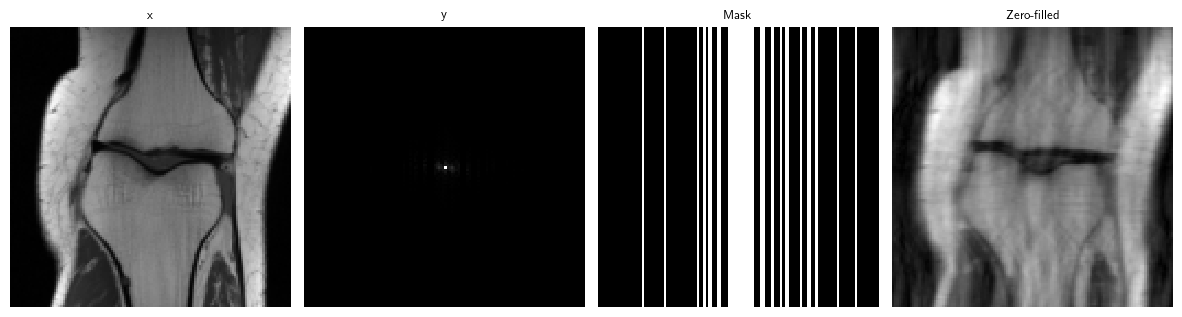

In [ ]:
x, y, params = next(iter(test_dataloader))
dinv.utils.plot({
    "x": x,
    "y": y,
    "Mask": params["mask"],
    "Zero-filled": physics.A_adjoint(y, **params)
}, figsize=(15, 4))

### Define trainer

In [ ]:
#| code-line-numbers: "1,4,22,24|2,5|6|7|8-9|1,11|10,12,13,14,15,16,17,18,19,23"

def train(loss: dinv.loss.Loss, epochs: int = 0):
    _model = model()
        
    trainer = dinv.Trainer(
        model = _model,
        physics = physics,
        optimizer = torch.optim.Adam(_model.parameters(), lr=1e-3),
        train_dataloader = train_dataloader,
        eval_dataloader = test_dataloader,
        epochs = epochs,
        losses = loss,
        scheduler = None,
        metrics = dinv.metric.PSNR(complex_abs=True),
        ckp_interval = 10,
        device = device,
        eval_interval = 1,
        save_path = "models",
        plot_images = False,
        wandb_vis = False,
    )

    trainer.train()
    trainer.plot_images = True
    return trainer

## 1. Equivariant imaging methods

### 1a. Equivariant imaging (EI) {.smaller}

The EI self-supervised loss [1] assumes that the set of signals is invariant to a group of transformations in order to learn from incomplete measurement data alone:

$\mathcal{L}_\text{EI}=\lVert T_g \hat{x} - f(A(T_g \hat{x}), A)\rVert_2^2$

where $\hat{x}=f(y, A)$ is a reconstructed signal and $T_g$ is a transformation sampled at random from a group $g\sim G$. EI was applied to MRI in [2]. Note that this works even when $A$ is fixed across the dataset as it constructs multiple _virtual_ operators.

Implementation: loss functions abstracted into `EILoss(...)`, keeping a modular structure.

. . .

See also: [Example - _"Self-supervised learning with Equivariant Imaging for MRI"_](https://deepinv.github.io/deepinv/auto_examples/self-supervised-learning/demo_equivariant_imaging.html); [Example - _"Image transformations for Equivariant Imaging"_](https://deepinv.github.io/deepinv/auto_examples/self-supervised-learning/demo_ei_transforms.html); [Docs - `deepinv.loss.EILoss`](https://deepinv.github.io/deepinv/api/stubs/deepinv.loss.EILoss.html).

[1] Chen D., Tachella J. & Davies M., [_"Equivariant Imaging: Learning Beyond the Range Space"_](https://arxiv.org/abs/2103.14756)  
[2] Chen D., Tachella J. & Davies M., [_"Robust Equivariant Imaging: a fully unsupervised framework for learning to image from noisy and partial measurements"_](https://arxiv.org/abs/2111.12855)  

### 1a. Equivariant Imaging Results {.smaller}

Test:  98%|███████████████████████████████████████████████████████████████████████▌ | 49/50 [00:09<00:00,  5.69it/s, PSNR=30.6, PSNR no learning=26.9]

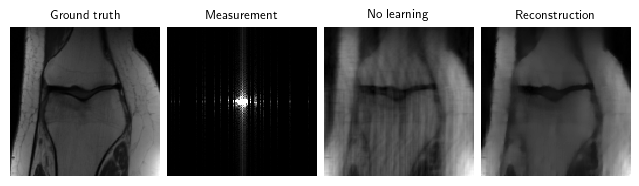

Test: 100%|█████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.24it/s, PSNR=30.6, PSNR no learning=26.9]


Test results:
PSNR no learning: 26.897 +- 2.730
PSNR: 30.643 +- 2.992


In [ ]:
#| code-line-numbers: "1-4|6-7|9-10|12|14-15"

loss = [
    dinv.loss.MCLoss(),
    dinv.loss.EILoss(transform=dinv.transform.Rotate())
]

# Set epochs > 0 to train the model
trainer = train(loss, epochs=0)

# Load pretrained model for 50 epochs, test on test dataset, and save sample reconstruction
trainer.load_model("models/pretrained/ei.pth.tar")

results["ei"] = trainer.test(test_dataloader)

physics.update_parameters(**params)
results["ei"]["sample"] = trainer.model(y, physics)

### 1b. Diffeomorphic-equivariant imaging {.smaller}

::: {.panel-tabset}

#### Summary

EI was extended beyond the Euclidean transformation group to the non-linear diffeomorphic group in [3] for MRI problems:

$\mathcal{L}_\text{Diffeo-EI}=\mathcal{L}_\text{EI}\text{ where }G=\text{Diff}(\mathbb{R}^n)$

See also: [Example - _"Image transforms for equivariance & augmentations"_](https://deepinv.github.io/deepinv/auto_examples/basics/demo_transforms.html).

[3] Wang A. & Davies M., [_"Fully unsupervised dynamic MRI reconstruction"_](https://arxiv.org/abs/2410.08646)

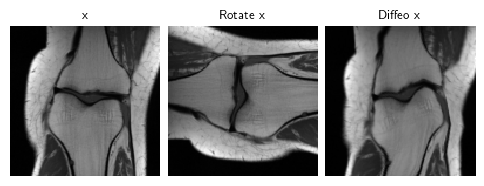

In [ ]:
dinv.utils.plot({"x": x, "Rotate x": dinv.transform.Rotate()(x), "Diffeo x": dinv.transform.CPABDiffeomorphism()(x)}, figsize=(6, 2))

#### Results

In [ ]:
#| output: false
loss = [
    dinv.loss.MCLoss(),
    dinv.loss.EILoss(transform=dinv.transform.CPABDiffeomorphism(device=device))
]

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [12]:
# Set epochs > 0 to train the model
trainer = train(loss, epochs=0)

The model has 2070091 trainable parameters


Test:  98%|███████████████████████████████████████████████████████████████████████▌ | 49/50 [00:11<00:00,  3.87it/s, PSNR=31.4, PSNR no learning=26.9]

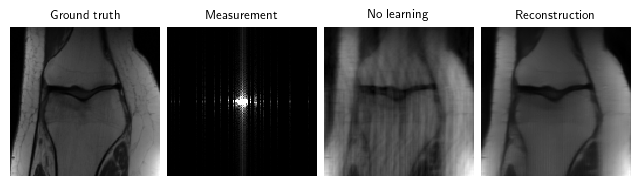

Test: 100%|█████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.22it/s, PSNR=31.4, PSNR no learning=26.9]


Test results:
PSNR no learning: 26.897 +- 2.730
PSNR: 31.388 +- 2.496


In [13]:
# Load pretrained model for 50 epochs, test on test dataset, and save sample reconstruction
trainer.load_model("models/pretrained/diffeo-ei.pth.tar")

results["diffeo-ei"] = trainer.test(test_dataloader)

physics.update_parameters(**params)
results["diffeo-ei"]["sample"] = trainer.model(y, physics)

:::

## 2. Multi-operator methods

### 2a. Multi-operator imaging (MOI) {.smaller}

::: {.panel-tabset}

#### Summary

The MOI self-supervised loss [4] can be used to learn when signals are observed via multiple (possibly incomplete) forward operators $\{A_g\}_{g=1}^{G}$, i.e. $y_i = A_{g_i}x_i$ where $g_i\in \{1,\dots,G\}$. The loss is constructed as follows:

$\mathcal{L}_\text{MOI}=\lVert\hat{x} - f(A_g\hat{x},A_g)\rVert_2^2$

where $\hat{x}=f(y,A_s)$ is a reconstructed signal (observed via operator $A_s$) and
$A_g$ is a forward operator sampled at random from a set $\{A_g\}_{g=1}^{G}$.

See also: [Example - _"Self-supervised learning from incomplete measurements of multiple operators."_](https://deepinv.github.io/deepinv/auto_examples/self-supervised-learning/demo_multioperator_imaging.html); [Docs - `deepinv.loss.MOILoss`](https://deepinv.github.io/deepinv/api/stubs/deepinv.loss.MOILoss.html).

[4] Chen D., Tachella J. & Davies M., [_"Unsupervised Learning From Incomplete Measurements for Inverse Problems"_](https://arxiv.org/abs/2201.12151)  

#### Results

In [14]:
loss = [
    dinv.loss.MCLoss(),
    dinv.loss.MOILoss(physics_generator=physics_generator)
]

In [15]:
# Set epochs > 0 to train the model
trainer = train(loss, epochs=0)

The model has 2070091 trainable parameters


Test:  98%|███████████████████████████████████████████████████████████████████████▌ | 49/50 [00:10<00:00,  4.76it/s, PSNR=31.3, PSNR no learning=26.9]

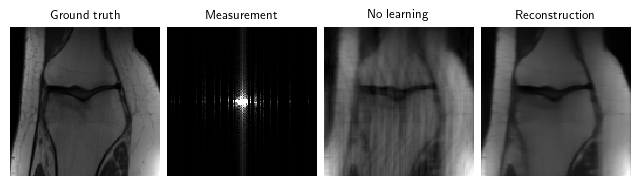

Test: 100%|█████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.55it/s, PSNR=31.3, PSNR no learning=26.9]


Test results:
PSNR no learning: 26.897 +- 2.730
PSNR: 31.260 +- 2.339


In [16]:
# Load pretrained model for 50 epochs, test on test dataset, and save sample reconstruction
trainer.load_model("models/pretrained/moi.pth.tar")

results["moi"] = trainer.test(test_dataloader)

physics.update_parameters(**params)
results["moi"]["sample"] = trainer.model(y, physics)

:::

### 2b. Multi-operator equivariant imaging (MO-EI) {.smaller}

::: {.panel-tabset}

#### Summary

One can combine the multi-operator and equivariant imaging losses to leverage an even greater set of virtual operators (using notation from above), introduced in [5]:

$\mathcal{L}_\text{MO-EI}=\lVert T_g\hat{x} - f(A_h(T_g \hat{x}), A_h)\rVert_2^2,\quad A_h\in\{A_h\}_{h=1}^{H},g\in G$

where $H$ is the set of operators and $G$ is the group.

Because of the modularity of DeepInverse, this is very easily implemented. See also: [Docs - `deepinv.loss.MOEILoss`](https://deepinv.github.io/deepinv/api/stubs/deepinv.loss.MOEILoss.html).

[5] Wang A. & Davies M., [_"Benchmarking Self-Supervised Methods for Accelerated MRI Reconstruction"_](https://arxiv.org/abs/2502.14009)

#### Results

In [17]:
loss = [
    dinv.loss.MCLoss(),
    dinv.loss.MOEILoss(transform=dinv.transform.CPABDiffeomorphism(device=device), physics_generator=physics_generator)
]

In [18]:
# Set epochs > 0 to train the model
trainer = train(loss, epochs=0)

The model has 2070091 trainable parameters


Test:  98%|███████████████████████████████████████████████████████████████████████▌ | 49/50 [00:11<00:00,  4.62it/s, PSNR=31.6, PSNR no learning=26.9]

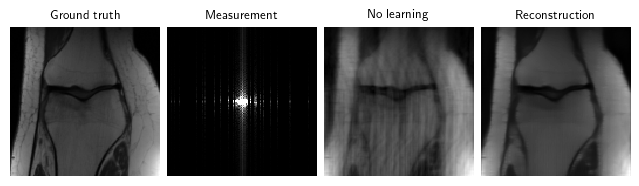

Test: 100%|█████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.19it/s, PSNR=31.6, PSNR no learning=26.9]


Test results:
PSNR no learning: 26.897 +- 2.730
PSNR: 31.601 +- 2.326


In [19]:
# Load pretrained model for 50 epochs, test on test dataset, and save sample reconstruction
trainer.load_model("models/pretrained/mo-ei.pth.tar")

results["mo-ei"] = trainer.test(test_dataloader)

physics.update_parameters(**params)
results["mo-ei"]["sample"] = trainer.model(y, physics)

:::

## 3. Measurement splitting methods

### 3a. Self-supervised data undersampling (SSDU) {.smaller}

::: {.panel-tabset}

#### Summary

The SSDU measurement splitting loss [6,7,8] splits the measurement $y\in\mathbb{R}^m$ and forward operator $A$ into two smaller pairs $(y_1\in\mathbb{R}^{m_1},A_1)$ and $(y_2\in\mathbb{R}^{m_2},A_2)$ to compute the self-supervised loss:

$\mathcal{L}_\text{SSDU}=\frac{m}{m_2}\lVert y_2 - A_2 f(y_1,A_1)\rVert_2^2$

where $f$ is the network, $A_1 = M_1A, A_2 = M_2A$, and $M_i$ are randomly generated masks (i.e. diagonal matrices) such that $M_1+M_2=\mathbb{I}_m$. At inference-time, SSDU simply uses the full measurements $\hat x=f(y,A)$.

See also: [Example - _"Self-supervised learning with measurement splitting"_](https://deepinv.github.io/deepinv/auto_examples/self-supervised-learning/demo_splitting_loss.html).

[6] Yaman B. et al., [_"SSDU"_](https://pubmed.ncbi.nlm.nih.gov/32614100/)  
[7] Liu J. et al., [_"RARE: Image Reconstruction using Deep Priors Learned without GT"_](https://arxiv.org/abs/1912.05854)  
[8] Eldeniz C. et al., [_"Phase2Phase..."_](https://journals.lww.com/investigativeradiology/abstract/2021/12000/phase2phase__respiratory_motion_resolved.4.aspx)  

#### Results

In [20]:
mask_generator = dinv.physics.generator.GaussianSplittingMaskGenerator((2, 128, 128), split_ratio=0.6, device=device, rng=rng)
loss = dinv.loss.SplittingLoss(mask_generator=mask_generator, eval_split_input=False)

In [21]:
# Set epochs > 0 to train the model
trainer = train(loss, epochs=0)

The model has 2070091 trainable parameters


Test:  98%|███████████████████████████████████████████████████████████████████████▌ | 49/50 [00:10<00:00,  5.05it/s, PSNR=26.8, PSNR no learning=26.9]

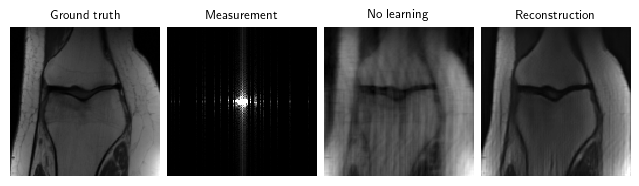

Test: 100%|█████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.90it/s, PSNR=26.8, PSNR no learning=26.9]


Test results:
PSNR no learning: 26.897 +- 2.730
PSNR: 26.796 +- 2.191


In [22]:
# Load pretrained model for 50 epochs, test on test dataset, and save sample reconstruction
trainer.load_model("models/pretrained/ssdu.pth.tar")

results["ssdu"] = trainer.test(test_dataloader)

physics.update_parameters(**params)
results["ssdu"]["sample"] = trainer.model(y, physics)

:::

### 3b. SSDU with test-time Monte Carlo {.smaller}

::: {.panel-tabset}

#### Summary

We can extend SSDU [6] during inference-time by averaging the model over multiple realizations of the random splitting, i.e.

$\hat{x} = \frac{1}{N}\sum_{i=1}^N f(y_1^{(i)},A_1^{(i)})$

where $N$ is the number of Monte-Carlo samples. The training loss function remains the same as SSDU. This was proposed in [9] for CT denoising, and has shown promising results in [3].

[9] Hendriksen A., Pelt D., Batenburg K., [_"Noise2Inverse: Self-supervised deep convolutional denoising for tomography"_](https://arxiv.org/abs/2001.11801)

#### Results

In [23]:
loss = dinv.loss.SplittingLoss(mask_generator=mask_generator, eval_split_input=True, eval_n_samples=20)

In [24]:
# Set epochs > 0 to train the model
trainer = train(loss, epochs=0)

The model has 2070091 trainable parameters


Test:  98%|███████████████████████████████████████████████████████████████████████▌ | 49/50 [03:16<00:03,  3.89s/it, PSNR=26.3, PSNR no learning=26.9]

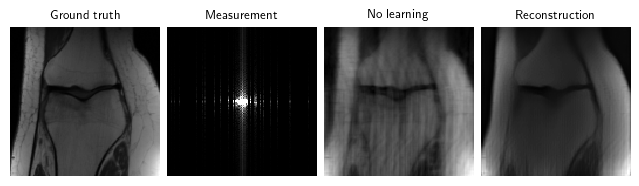

Test: 100%|█████████████████████████████████████████████████████████████████████████| 50/50 [03:16<00:00,  3.94s/it, PSNR=26.3, PSNR no learning=26.9]


Test results:
PSNR no learning: 26.897 +- 2.730
PSNR: 26.282 +- 2.030


In [25]:
# Load pretrained SSDU model for 50 epochs, test on test dataset, and save sample reconstruction
trainer.load_model("models/pretrained/ssdu.pth.tar")

results["noise2inverse"] = trainer.test(test_dataloader)

physics.update_parameters(**params)
results["noise2inverse"]["sample"] = trainer.model(y, physics)

:::

### 3c. Weighted-SSDU {.smaller}

::: {.panel-tabset}

#### Summary

The Weighted-SSDU [10] loss frames SSDU [6] as a Bernoulli-noise special case of Noisier2Noise [11] and propose a weighting to the SSDU loss to improve SSDU:

$\mathcal{L}_\text{Weighted-SSDU}=(1-\mathbf{K})^{-1/2}\mathcal{L}_\text{SSDU}$

where $\mathbf{K}$ depends on the PDF of the measurement mask $M$ and the splitting mask $M_1$.

[10] Millard C. & Chiew M., [_"A theoretical framework for self-supervised MR image reconstruction using sub-sampling via variable density Noisier2Noise"_](https://arxiv.org/abs/2205.10278)  
[11] Moran N. et al., [_"Noisier2Noise: Learning to Denoise from Unpaired Noisy Data"_](https://arxiv.org/abs/1910.11908)  

#### Results

In [ ]:
split_generator = dinv.physics.generator.GaussianMaskGenerator(img_size=(128, 128), acceleration=2, rng=rng, device=device)

loss = dinv.loss.WeightedSplittingLoss(
    mask_generator=dinv.physics.generator.MultiplicativeSplittingMaskGenerator((1, 128, 128), split_generator),
    physics_generator=physics_generator
)

In [9]:
# Set epochs > 0 to train the model
trainer = train(loss, epochs=0)

The model has 2070091 trainable parameters


Test:  98%|███████████████████████████████████████████████████████████████████████▌ | 49/50 [00:27<00:00,  2.22it/s, PSNR=26.8, PSNR no learning=26.9]

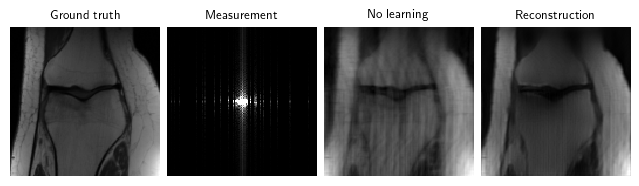

Test: 100%|█████████████████████████████████████████████████████████████████████████| 50/50 [00:28<00:00,  1.76it/s, PSNR=26.8, PSNR no learning=26.9]


Test results:
PSNR no learning: 26.897 +- 2.730
PSNR: 26.780 +- 1.295


In [ ]:
# Load pretrained model for 50 epochs, test on test dataset, and save sample reconstruction
trainer.load_model("models/pretrained/weighted-ssdu.pth.tar")

results["weighted-ssdu"] = trainer.test(test_dataloader)

physics.update_parameters(**params)
results["weighted-ssdu"]["sample"] = trainer.model(y, physics)

:::

## 4. Other methods {.smaller}

We have numerous other self-supervised learning methods implemented in [DeepInverse](https://deepinv.github.io/deepinv/user_guide/training/loss.html#self-supervised-learning) and benchmarked in [_"Benchmarking Self-Supervised Methods for Accelerated MRI Reconstruction"_](https://arxiv.org/abs/2502.14009), including:

- Adversarial losses [12, 13, 14]: [_Example - Imaging inverse problems with adversarial networks_](https://deepinv.github.io/deepinv/auto_examples/adversarial-learning/demo_gan_imaging.html).
- Deep Image Prior [15]: [_Example - Reconstructing an image using the deep image prior_](https://deepinv.github.io/deepinv/auto_examples/basics/demo_dip.html).
- Denoising e.g. [16]: [_User Guide - Self-supervised denoising losses_](https://deepinv.github.io/deepinv/user_guide/training/loss.html#id2).

[12] Bora A., Price E. & Dimakis A., [_"AmbientGAN"_](https://openreview.net/forum?id=Hy7fDog0b)  
[13] Pajot A., de Bezenac E., Gallinari P., [_"Unsupervised Adversarial Image Reconstruction"_](https://openreview.net/forum?id=BJg4Z3RqF7)  
[14] Cole E. et al., [_"Fast Unsupervised MRI Reconstruction ... Using GANs"_](https://openaccess.thecvf.com/content/ICCV2021W/LCI/html/Cole_Fast_Unsupervised_MRI_Reconstruction_Without_Fully-Sampled_Ground_Truth_Data_Using_ICCVW_2021_paper.html)  
[15] Darestani M. & Heckel R., [_"Accelerated MRI with Un-trained Neural Networks"_](https://arxiv.org/abs/2007.02471)  
[16] Tachella J., Davies M. & Jacques L., [_"UNSURE"_](https://arxiv.org/abs/2409.01985)  

## 5. Baselines

::: {.panel-tabset}

#### Summary

We also provide an upper-limit experiment using oracle supervised learning...

$\mathcal{L}_\text{sup}=\lVert\hat x-x\rVert_2^2$

...and a naive unsupervised baseline using only measurement consistency:

$\mathcal{L}_\text{MC}=\lVert A\hat x-y\rVert_2^2$

#### Results

The model has 2070091 trainable parameters


Test:  98%|███████████████████████████████████████████████████████████████████████▌ | 49/50 [00:10<00:00,  4.93it/s, PSNR=31.8, PSNR no learning=26.9]

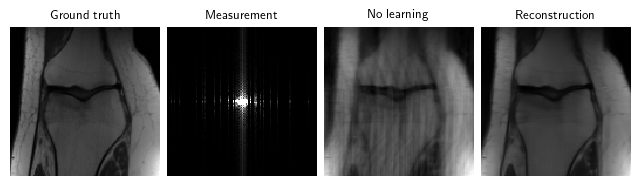

Test: 100%|█████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.77it/s, PSNR=31.8, PSNR no learning=26.9]


Test results:
PSNR no learning: 26.897 +- 2.730
PSNR: 31.779 +- 2.595


In [26]:
trainer = train(dinv.loss.SupLoss(), epochs=0)
trainer.load_model("models/pretrained/sup.pth.tar")
results["sup"] = trainer.test(test_dataloader)
physics.update_parameters(**params)
results["sup"]["sample"] = trainer.model(y, physics)

The model has 2070091 trainable parameters


Test:  98%|███████████████████████████████████████████████████████████████████████▌ | 49/50 [00:10<00:00,  4.54it/s, PSNR=26.9, PSNR no learning=26.9]

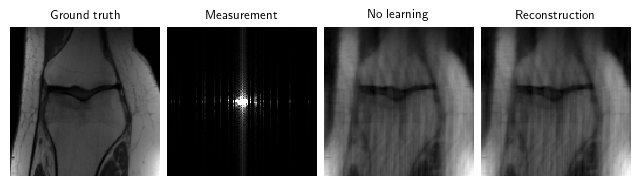

Test: 100%|█████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.67it/s, PSNR=26.9, PSNR no learning=26.9]


Test results:
PSNR no learning: 26.897 +- 2.730
PSNR: 26.896 +- 2.730


In [27]:
trainer = train(dinv.loss.MCLoss(), epochs=0)
trainer.load_model("models/pretrained/mc.pth.tar")
results["mc"] = trainer.test(test_dataloader)
physics.update_parameters(**params)
results["mc"]["sample"] = trainer.model(y, physics)

:::

## 6. Side-by-side comparison {.smaller}

Note: these results are for a toy problem on 128x128 images trained for 50 epochs. For full benchmark results on full datasets see the paper [_"Benchmarking Self-Supervised Methods for Accelerated MRI Reconstruction"_](https://arxiv.org/abs/2502.14009).

In [28]:
import pandas as pd
pd.DataFrame.from_dict(results, orient="index", columns=("PSNR", "PSNR no learning")).sort_values('PSNR', ascending=False).round(3).transpose()

,sup,mo-ei,diffeo-ei,moi,ei,mc,ssdu,noise2inverse
PSNR,31.779,31.601,31.388,31.260,30.643,26.896,26.796,26.282
PSNR no learning,26.897,26.897,26.897,26.897,26.897,26.897,26.897,26.897


### 6. Side-by-side comparison {.smaller}

Note: these results are for a toy problem on 128x128 images trained for 50 epochs. For full benchmark results on full datasets see the paper [_"Benchmarking Self-Supervised Methods for Accelerated MRI Reconstruction"_](https://arxiv.org/abs/2502.14009).

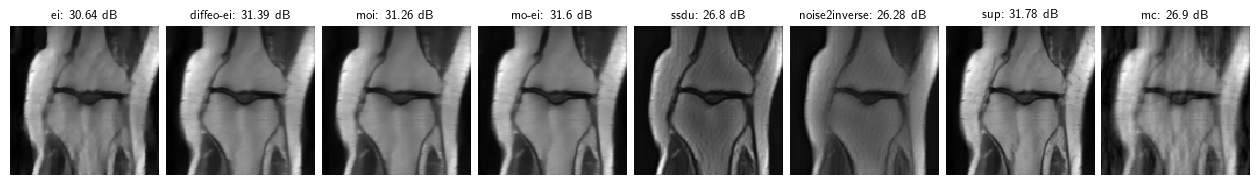

In [29]:
dinv.utils.plot({f"{k}: {round(v['PSNR'], 2)} dB": v['sample'] for (k, v) in results.items()})

### 7. Summary {.smaller}

| Method        | Implementation                                         |
|---------------|--------------------------------------------------------|
| MC            | `dinv.loss.MCLoss()`                              |
| SSDU          | `dinv.loss.SplittingLoss(eval_split_input=False)` |
| Noise2Inverse | `dinv.loss.SplittingLoss(eval_split_input=True)`  |
| Weighted-SSDU | `dinv.loss.WeightedSplittingLoss()`               |
| Adversarial   | `dinv.loss.UnsupAdversarialGeneratorLoss()`       |
| UAIR          | `dinv.loss.UAIRGeneratorLoss()`                   |
| VORTEX        | `dinv.loss.VORTEXLoss()`                          |
| EI            | `dinv.loss.EILoss()`                              |
| MOI           | `dinv.loss.MOILoss()`                             |
| MO-EI         | `dinv.loss.MOEILoss()`                            |

## Citation

If you found this useful, please cite the [paper](https://arxiv.org/abs/2502.14009) using:

```bibtex
@misc{wang2025benchmarking,
      title={Benchmarking Self-Supervised Methods for Accelerated MRI Reconstruction}, 
      author={Andrew Wang and Mike Davies},
      year={2025},
      eprint={2502.14009},
      archivePrefix={arXiv},
      primaryClass={eess.IV},
      url={https://arxiv.org/abs/2502.14009}, 
}
```